# CRYPTO PREDICTOR

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import torch
import warnings
from lstm import LSTM

from indicators import moving_average, stochastic_oscillator, fibonacci_retracement

,Open,High,Low,Close,Volume,MA,%K,%D,Fibonacci_0.0,Fibonacci_0.236,Fibonacci_0.382,Fibonacci_0.5,Fibonacci_0.618,Fibonacci_0.764,Fibonacci_1.0
Date,,,,,,,,,,,,,,,
2014-10-02,383.988007,385.497009,372.946014,375.071991,21777700,386.031995,4.085578,10.951746,385.497009,382.534974,380.702529,379.221512,377.740494,375.908049,372.946014
2014-10-03,375.181000,377.695007,357.859009,359.511993,30901200,379.615853,1.974939,6.500989,377.695007,373.013711,370.117656,367.777008,365.436360,362.540305,357.859009
2014-10-04,359.891998,364.487000,325.885986,328.865997,47236500,369.522426,2.576281,2.878933,364.487000,355.377161,349.741413,345.186493,340.631573,334.995825,325.885986
2014-10-05,328.915985,341.800995,289.295990,320.510010,83308096,361.426570,20.500336,8.350519,341.800995,329.409814,321.744083,315.548493,309.352902,301.687171,289.295990
2014-10-06,320.389008,345.134003,302.559998,330.079010,79011800,354.942570,26.784939,16.620519,345.134003,335.086538,328.870733,323.847001,318.823268,312.607463,302.559998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-06,29538.859375,29820.126953,28468.966797,28904.623047,15913866714,28904.848493,62.693360,69.221587,29820.126953,29501.253156,29303.983773,29144.546875,28985.109977,28787.840594,28468.966797
2023-05-07,28901.623047,29157.517578,28441.367188,28454.978516,11301355486,28788.587333,47.320836,64.745986,29157.517578,28988.506086,28883.948129,28799.442383,28714.936637,28610.378680,28441.367188
2023-05-08,28450.457031,28663.271484,27310.134766,27694.273438,19122903752,28731.830915,17.444697,42.486298,28663.271484,28343.931219,28146.373258,27986.703125,27827.032992,27629.475031,27310.134766


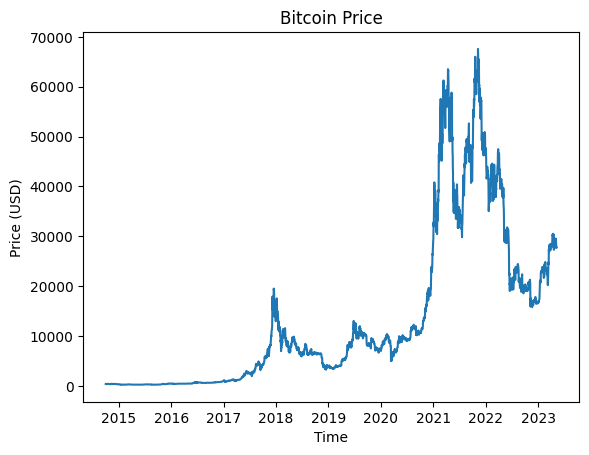

In [2]:
# read data and plot price in time
df = pd.read_csv('data/BTC-USD.csv', index_col='Date', parse_dates=True)
df.drop(columns='Adj Close', inplace=True)

df = moving_average(df, 7)
df = stochastic_oscillator(df, k_period=14, d_period=3)
df = fibonacci_retracement(df)

df.dropna(inplace=True)

display(df)

plt.plot(df['Close'])
plt.xlabel('Time')
plt.ylabel('Price (USD)')
plt.title('Bitcoin Price')
plt.show()

In [3]:
X = df.drop(columns=['Close'])
y = {"Close": df.Close.values, "Date": df.index.values}

# MinMaxScaler - scale data proportionally to the range of the data
min_max_scaler = MinMaxScaler()
y_standarized = min_max_scaler.fit_transform(y["Close"].reshape(-1, 1))

# StandardScaler - scale data to have a mean of 0 and a standard deviation of 1
standard_scaler = StandardScaler()
x_standarized = standard_scaler.fit_transform(X)

print(x_standarized)
print(y_standarized)

[[-0.81099492 -0.81107063 -0.81251474 ... -0.81213971 -0.81231116
  -0.81251474]
 [-0.81154352 -0.81154462 -0.81348263 ... -0.81291272 -0.81315772
  -0.81348263]
 [-0.81249589 -0.81234704 -0.81553382 ... -0.81447109 -0.81490208
  -0.81553382]
 ...
 [ 0.93729514  0.90686664  0.91560556 ...  0.91237361  0.91362662
   0.91560556]
 [ 0.89024118  0.85572111  0.9198055  ...  0.89471111  0.90421184
   0.9198055 ]
 [ 0.88725973  0.88586299  0.89934222 ...  0.89423377  0.89619409
   0.89934222]]
[[0.00292288]
 [0.00269198]
 [0.00223721]
 ...
 [0.40832009]
 [0.40779333]
 [0.40885202]]


In [4]:
# create sequences from standarized data
def create_sequences(x_data, y_data, x_step, y_step):
    X, y = list(), list()
    for i in range(len(x_data)):
        x_end_idx = i + x_step
        y_end_ix = x_end_idx + y_step - 1
        if y_end_ix > len(x_data):
            break
        new_seq_x, new_seq_y = x_data[i:x_end_idx], y_data[x_end_idx-1:y_end_ix, -1]
        X.append(new_seq_x), y.append(new_seq_y)
    return np.array(X), np.array(y)

SEQUENCE_INPUT_LENGTH = 100
SEQUENCE_OUTPUT_LENGTH = 50

X_ss, y_mm = create_sequences(x_standarized, y_standarized, SEQUENCE_INPUT_LENGTH, SEQUENCE_OUTPUT_LENGTH)
print(X_ss.shape, y_mm.shape)

(2995, 100, 14) (2995, 50)


In [5]:

SEQUENCE_LENGTH = SEQUENCE_INPUT_LENGTH + SEQUENCE_OUTPUT_LENGTH

total_num_of_sequences = len(X_ss)
test_data_start_sequence_index = total_num_of_sequences - SEQUENCE_LENGTH

X_train = X_ss[:-SEQUENCE_LENGTH]
X_test = X_ss[-SEQUENCE_LENGTH:]

y_train = y_mm[:-SEQUENCE_LENGTH]
y_test = y_mm[-SEQUENCE_LENGTH:]

print("Training Shape:", X_train.shape, y_train.shape)
print("Testing Shape:", X_test.shape, y_test.shape)

Training Shape: (2845, 100, 14) (2845, 50)
Testing Shape: (150, 100, 14) (150, 50)


In [6]:
# convert to pytorch tensors
X_train_tensors = torch.Tensor(X_train)
X_test_tensors = torch.Tensor(X_test)

y_train_tensors = torch.Tensor(y_train)
y_test_tensors = torch.Tensor(y_test)

In [7]:
# reshaping to rows, timestamps, features
X_train_tensors_final = torch.reshape(X_train_tensors,
                                      (X_train_tensors.shape[0],
                                       SEQUENCE_INPUT_LENGTH,
                                       X_train_tensors.shape[2]))
X_test_tensors_final = torch.reshape(X_test_tensors,
                                     (X_test_tensors.shape[0],
                                      SEQUENCE_INPUT_LENGTH,
                                      X_test_tensors.shape[2]))

print("Training Shape:", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape:", X_test_tensors_final.shape, y_test_tensors.shape)


Training Shape: torch.Size([2845, 100, 14]) torch.Size([2845, 50])
Testing Shape: torch.Size([150, 100, 14]) torch.Size([150, 50])


In [8]:
X_check, y_check = create_sequences(X, y['Close'].reshape(-1, 1), SEQUENCE_INPUT_LENGTH, SEQUENCE_OUTPUT_LENGTH)
display(X.shape, y['Close'].shape)

(3143, 14)

(3143,)

In [9]:
# Steps:
# 1. Set model to training mode
# 2. Feed the training data
# 3. Reset the gradients back to zero
# 4. Compute the loss for the training data
# 5. Backpropagate the loss
# 6. Update the parameters
# 7. Set model to evaluation mode
# 8. Feed the test data
# 9. Compute the loss for the test data

def training_loop(num_of_epochs, lstm: LSTM, optimiser, loss_fn, X_train, y_train, X_test, y_test):
    for epoch in range(num_of_epochs):
        lstm.train()
        outputs = lstm.forward(X_train)
        optimiser.zero_grad()
        loss = loss_fn(outputs, y_train)
        loss.backward()
        optimiser.step()
        lstm.eval()
        test_preds = lstm(X_test)
        test_loss = loss_fn(test_preds, y_test)
        if epoch % 100 == 0:
            print("Epoch: %d, train loss: %1.5f, test loss: %1.5f" % (epoch,
                                                                      loss.item(),
                                                                      test_loss.item()))


In [10]:
warnings.filterwarnings('ignore')

num_of_epochs = 500
learning_rate = 0.01

# number of features
input_size = 14

hidden_size = 64
num_layers = 1
num_classes = SEQUENCE_OUTPUT_LENGTH

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

loss_fn = torch.nn.MSELoss()

# Adam - Adaptive Moment Estimation
optimiser = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

In [11]:
training_loop(num_of_epochs=num_of_epochs,
              lstm=lstm,
              optimiser=optimiser,
              loss_fn=loss_fn,
              X_train=X_train_tensors_final,
              y_train=y_train_tensors,
              X_test=X_test_tensors_final,
              y_test=y_test_tensors)

Epoch: 0, train loss: 0.09694, test loss: 0.09958
Epoch: 100, train loss: 0.00343, test loss: 0.00584
Epoch: 200, train loss: 0.00307, test loss: 0.00582


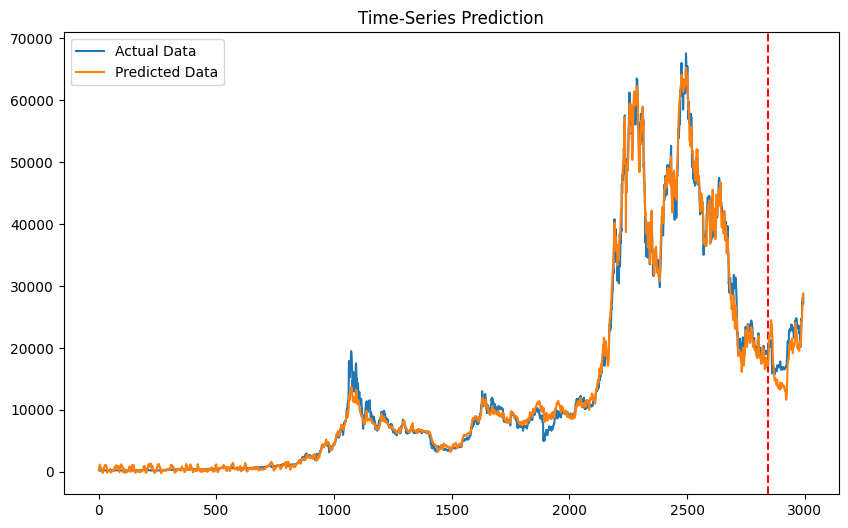

In [12]:
df_X_ss = standard_scaler.transform(df.drop(columns=['Close']))
df_y_mm = min_max_scaler.transform(df.Close.values.reshape(-1, 1))

df_X_ss, df_y_mm = create_sequences(df_X_ss, df_y_mm, SEQUENCE_INPUT_LENGTH, SEQUENCE_OUTPUT_LENGTH)

df_X_ss = torch.Tensor(df_X_ss)
df_y_mm = torch.Tensor(df_y_mm)

df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], SEQUENCE_INPUT_LENGTH, df_X_ss.shape[2]))

train_predict = lstm(df_X_ss)
data_predict = train_predict.data.numpy()
dataY_plot = df_y_mm.data.numpy()

data_predict = min_max_scaler.inverse_transform(data_predict)
dataY_plot = min_max_scaler.inverse_transform(dataY_plot)
true, preds = [], []
for i in range(len(dataY_plot)):
    true.append(dataY_plot[i][0])
for i in range(len(data_predict)):
    preds.append(data_predict[i][0])
plt.figure(figsize=(10,6))
plt.axvline(x=test_data_start_sequence_index, c='r', linestyle='--')

plt.plot(true, label='Actual Data')
plt.plot(preds, label='Predicted Data')
plt.title('Time-Series Prediction')
plt.legend()
plt.show() 

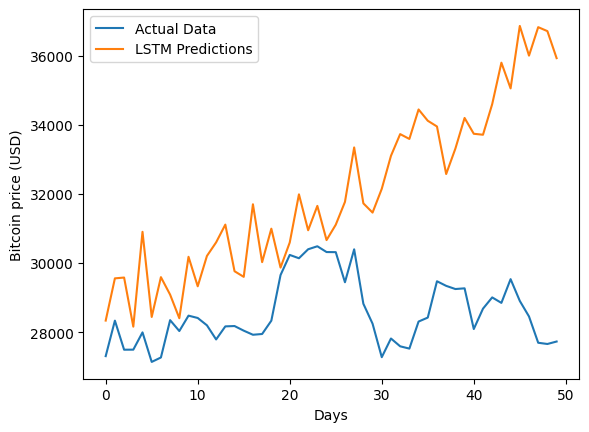

In [13]:
test_predict = lstm(X_test_tensors_final[-1].unsqueeze(0))
test_predict = test_predict.detach().numpy()
test_predict = min_max_scaler.inverse_transform(test_predict)
test_predict = test_predict[0].tolist()

test_target = y_test_tensors[-1].detach().numpy()
test_target = min_max_scaler.inverse_transform(test_target.reshape(1, -1))
test_target = test_target[0].tolist()

plt.plot(test_target, label="Actual Data")
plt.plot(test_predict, label="LSTM Predictions")
plt.xlabel('Days')
plt.ylabel('Bitcoin price (USD)')
plt.legend()
plt.show()

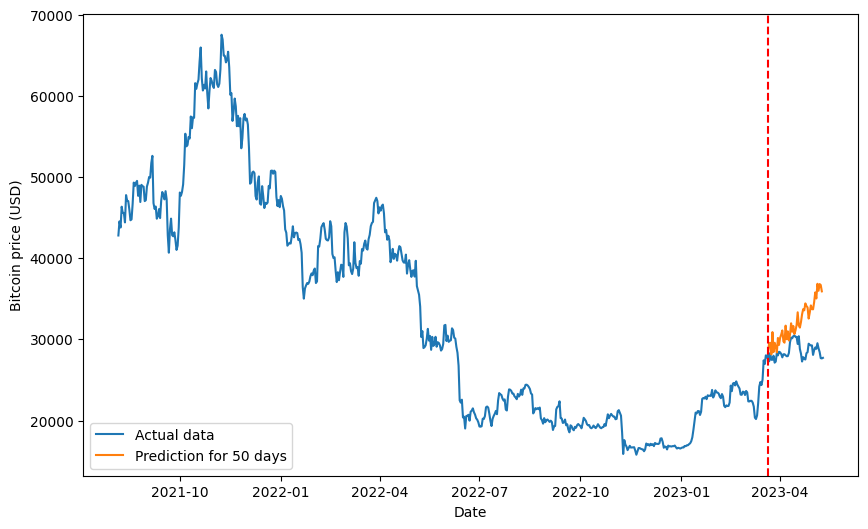

In [14]:
plt.figure(figsize=(10,6))

START_DATE_INDEX = 2500

start_date = y['Date'][START_DATE_INDEX]
last_date = y['Date'][-1]
num_days = len(y['Close']) - START_DATE_INDEX

# plot actual data
actual_date_range = pd.date_range(start=start_date, periods=num_days, freq='D')
plt.plot(actual_date_range, y['Close'][START_DATE_INDEX:], label='Actual data')

# plot predictions
prediction_date_range = pd.date_range(start=last_date - pd.Timedelta(days=SEQUENCE_OUTPUT_LENGTH), periods=SEQUENCE_OUTPUT_LENGTH, freq='D')
plt.plot(prediction_date_range, test_predict, label='Prediction for ' + str(SEQUENCE_OUTPUT_LENGTH) + ' days')

# plot vertical line to indicate start of predictions
plt.axvline(x=last_date - pd.Timedelta(days=SEQUENCE_OUTPUT_LENGTH), c='r', linestyle='--')

plt.xlabel('Date')
plt.ylabel('Bitcoin price (USD)')
plt.legend()
plt.show()